In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_parquet('friends2.parquet')
df.head(3)

,id,bdate,city,common_count,university_name,graduation,relation,universities,schools,sex,is_closed,mutual_friends,education_status,relation_partner,political,alcohol,life_main,people_main,religion,smoking,name,deactivated,school_name
0,1193834,18.1,Тверь,3,None,-1,None,[],[],2,False,"[54824441, 179527549, 385680044]",None,None,монархические,None,None,None,Православие,None,Игорь Марченкофф,None,None
1,1762723,18.1.1970,Тверь,5,ТвГУ,1993,None,"[{'chair': None, 'chair_name': None, 'city': 1...","[{'city': 175, 'class': '', 'class_id': 0.0, '...",1,True,"[172826326, 187783283, 232523985, 263499805, 4...",None,None,None,None,None,None,Православие,None,Елена Круглая,None,Школа № 6
2,2612800,22.11,Санкт-Петербург,1,None,-1,None,[],[],1,False,[276078718],None,None,None,None,None,None,None,None,Мария Остапова,None,None


# Forming graph

In [3]:
nodes = [
    {
        'id': fr.id,
        'name': fr['name'],
        'sex': fr.sex,
        'city': fr.city,
        'university_name': fr.university_name,
        'school_name': fr.school_name,
        'education_status': fr.education_status,
        'political': fr.political,
        'alcohol': fr.alcohol,
        'smoking': fr.smoking,
        'is_closed': fr.is_closed
    }
    for _, fr in df.iterrows()
]

In [4]:
edges = [(el['id'], el['mutual_friends']) for el in df[['id', 'mutual_friends']].explode('mutual_friends').dropna().to_dict(orient='records')]
edges = sorted(set(tuple(sorted(edge)) for edge in edges))
edges[:5]

[(1193834, 54824441),
 (1193834, 179527549),
 (1193834, 385680044),
 (1762723, 172826326),
 (1762723, 187783283)]

# DataFrame for visualization CosmoGraph

In [31]:
pd.DataFrame({
    'source': [e[0] for e in edges],
    'target': [e[1] for e in edges]
}).to_csv('edges.csv', index=False)

In [7]:
nodes_df = pd.DataFrame(nodes)
nodes_df.sex = nodes_df.sex.apply(lambda x: 1 if x == 2 else 2)
nodes_df

,id,name,sex,city,university_name,school_name,education_status,political,alcohol,smoking,is_closed
0,1193834,Игорь Марченкофф,1,Тверь,None,None,None,монархические,None,None,False
1,1762723,Елена Круглая,2,Тверь,ТвГУ,Школа № 6,None,None,None,None,True
2,2612800,Мария Остапова,2,Санкт-Петербург,None,None,None,None,None,None,False
3,4510163,Ольга Александровна,2,Москва,РТУ МИРЭА,None,Кандидат наук,None,None,резко негативное,True
4,37460188,Василий Уткин,1,None,None,Лицей № 4,None,умеренные,резко негативное,резко негативное,False
...,...,...,...,...,...,...,...,...,...,...,...
89,466114898,Сергей Валиев,1,Тверь,None,None,None,None,None,None,False
90,505679418,Дмитрий Новиков,1,Тверь,ТвГУ,Тверской педагогический колледж (бывш. ТМПУ),None,None,None,None,True
91,554605837,Алексей Гешко,1,None,ТвГУ,None,None,None,None,None,False
92,561048343,Аделина Исенцова,2,Москва,None,None,None,None,None,None,False


In [8]:
nodes_df.isna().sum() / len(nodes_df) * 100

id                   0.000000
name                 0.000000
sex                  0.000000
city                28.723404
university_name     65.957447
school_name         67.021277
education_status    84.042553
political           90.425532
alcohol             91.489362
smoking             84.042553
is_closed            0.000000
dtype: float64

In [37]:
nodes_df.to_csv('nodes.csv', index=False)

# Summary

In [9]:
G_full = nx.Graph()
G_full.add_nodes_from(list(zip(nodes_df.id.tolist(), nodes)))
G_full.add_edges_from(edges)

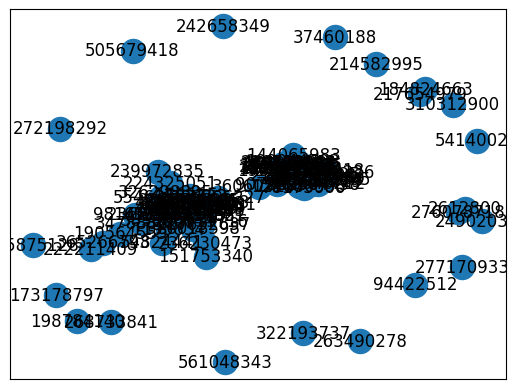

In [10]:
nx.draw_networkx(G_full)

In [11]:
G = G_full.subgraph(max(nx.connected_components(G_full), key=len)).copy()

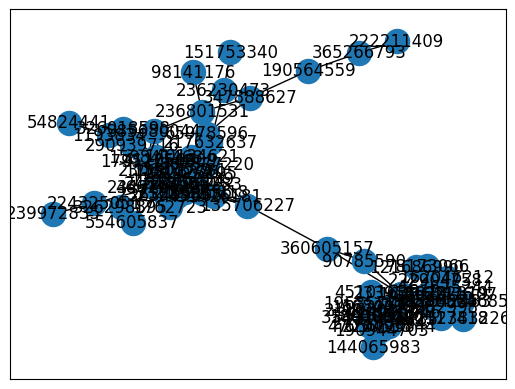

In [12]:
nx.draw_networkx(G)

In [13]:
len(G)

73

In [14]:
len(G.edges())

283

In [15]:
nx.diameter(G)

10

In [230]:
nx.radius(G)

5

In [15]:
# глобальный коэффициент кластеризации (тразнитивность)
nx.transitivity(G)

0.6292286874154263

In [16]:
# средний локальный коэффициент кластеризации
nx.average_clustering(G)

0.5368536229938327

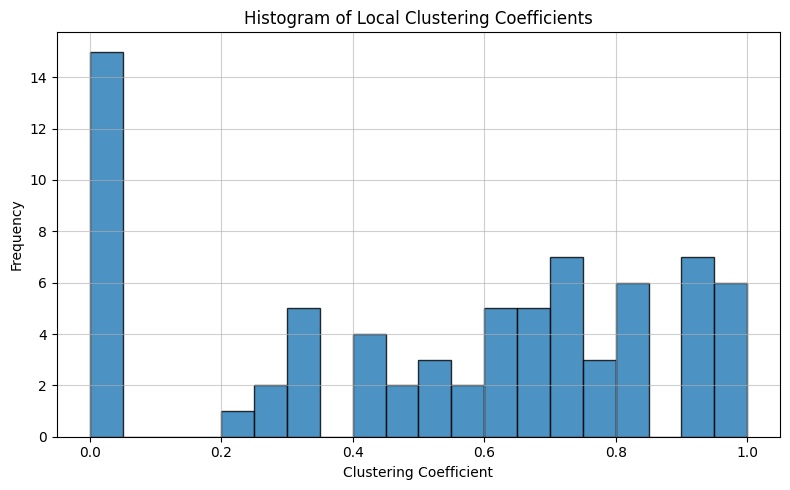

In [17]:
plt.figure(figsize=(8,5))
plt.hist(nx.clustering(G).values(), bins=20, edgecolor="black", alpha=0.8)
plt.title("Histogram of Local Clustering Coefficients")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
nx.average_shortest_path_length(G)

4.056316590563166

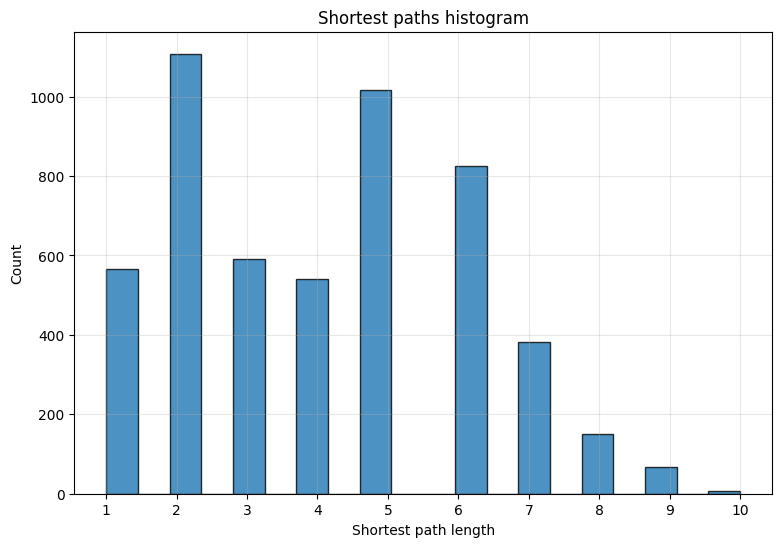

In [37]:
shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

path_lengths = []
for source in shortest_paths:
    for target in shortest_paths[source]:
        if source != target:
            path_lengths.append(shortest_paths[source][target])

plt.figure(figsize=(9,6))
plt.hist(path_lengths, bins='auto', edgecolor='black', alpha=0.8)
plt.title('Shortest paths histogram')
plt.xlabel('Shortest path length')
plt.ylabel('Count')
plt.xticks(list(range(1, max(path_lengths) + 1)))
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
np.unique(path_lengths, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 566, 1108,  592,  540, 1016,  826,  382,  150,   68,    8],
       dtype=int64))

## Degree distribution 

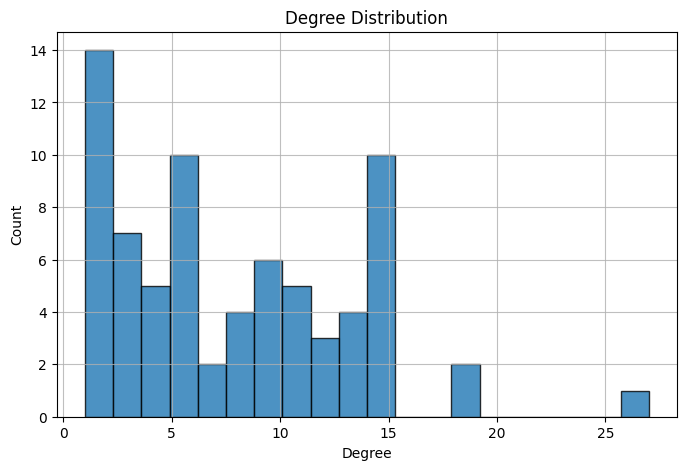

In [91]:
degrees = [degree for _, degree in G.degree()]
unique_degrees, counts = np.unique(degrees, return_counts=True)

plt.figure(figsize=(8, 5))
#plt.bar(unique_degrees, counts, width=0.8, alpha=0.8, edgecolor='black')
plt.hist(degrees, alpha=0.8, edgecolor='black', bins=20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.grid(alpha=0.8)
plt.show()

(array([21., 15.,  6., 11.,  7., 10.,  2.,  0.,  0.,  1.]),
 array([ 1. ,  3.6,  6.2,  8.8, 11.4, 14. , 16.6, 19.2, 21.8, 24.4, 27. ]),
 <BarContainer object of 10 artists>)

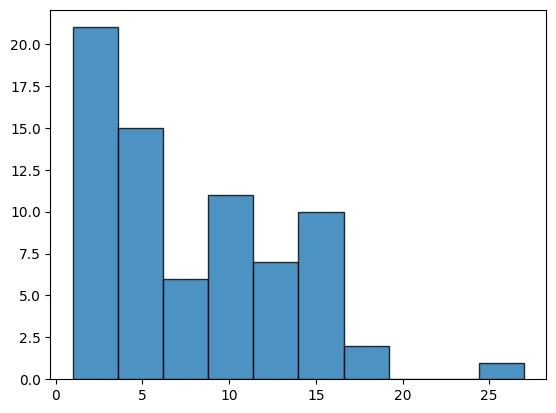

In [30]:
plt.hist(degrees, alpha=0.8, edgecolor='black', bins=10)

In [106]:
degrees = sorted(degrees)
degrees[:5]

[1, 1, 1, 1, 1]

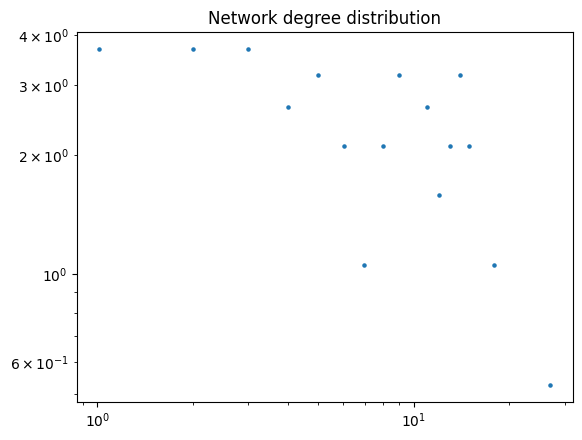

In [107]:
hist, bin_edges = np.histogram(degrees, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Network degree distribution')
plt.xscale('log')
plt.yscale('log')

In [108]:
def alpha_lin_bins(x_train, bins):
    hist, bin_edges = np.histogram(x_train, bins=bins, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    idx = np.argwhere(hist > 0)
    x1 = np.log(bin_centers[idx])[:, 0]
    x2 = np.ones(len(idx))
    X = np.stack([x1, x2], axis=1)
    y = np.log(hist[idx])
    coef, intercept = (np.linalg.pinv(X) @ y)[:, 0]
    return -coef

In [109]:
def power_law_cdf(x, alpha, x_min):
    return 1 - (x / x_min) ** (-alpha + 1)

def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

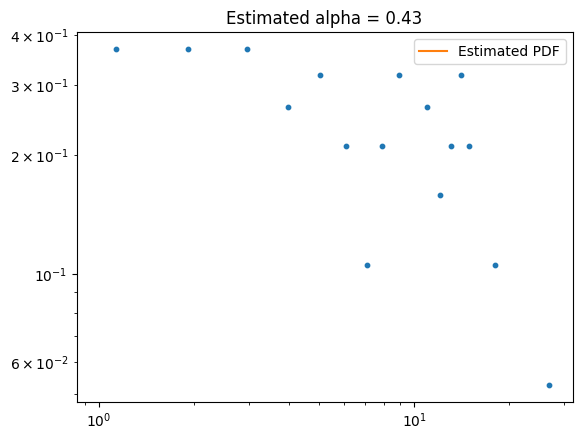

In [110]:
bins = 100

hist, bin_edges = np.histogram(degrees, bins=bins, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)

hat_alpha = alpha_lin_bins(degrees, bins)
x_space = np.linspace(min(degrees), max(degrees), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, min(degrees)),
         label='Estimated PDF', c='tab:orange')
plt.legend()
plt.title('Estimated alpha = {:.2f}'.format(hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

$ \gamma < 1 :( $

In [111]:
from scipy import stats
import scipy

In [112]:
def get_alpha(samples, x_min):
    return 1 + len(samples) / np.sum(np.log(samples / x_min))

def mle_power_law_params(degree_sequence):
    unique_degrees = np.unique(np.round(degree_sequence))
    best_x_min = None
    best_alpha = None
    min_D = float('inf')
    for x_min in unique_degrees[:-1]:
        cur_degrees = np.sort(degree_sequence[degree_sequence >= x_min])
        cur_alpha = get_alpha(cur_degrees, x_min)
        D, _ = scipy.stats.kstest(cur_degrees, power_law_cdf, args=(cur_alpha, x_min))
        if D < min_D:
            best_x_min = x_min
            best_alpha = cur_alpha
            min_D = D
    return best_alpha, best_x_min

In [113]:
hat_alpha, hat_x_min = mle_power_law_params(np.array(degrees))

In [114]:
hat_alpha

6.31984285400007

In [115]:
hat_x_min

12

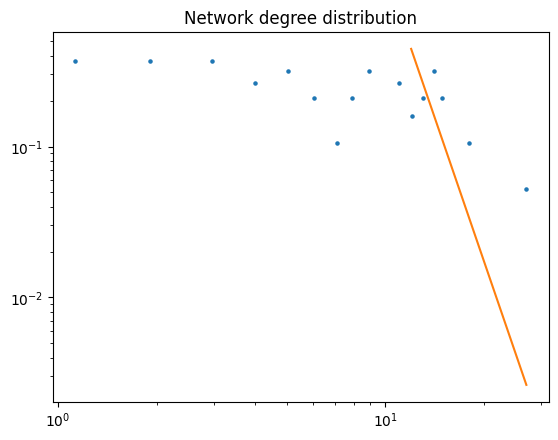

In [116]:
hist, bin_edges = np.histogram(degrees, bins=100, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Network degree distribution')

x_space = np.linspace(hat_x_min, max(degrees), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min),
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')

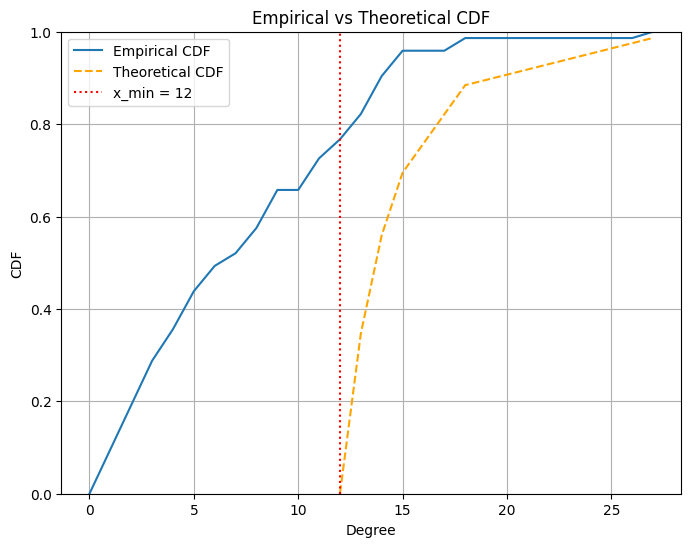

In [124]:
sorted_degrees = np.sort(degrees)
cdf_empirical = np.cumsum(nx.degree_histogram(G)) / len(G)

def power_law_cdf(x, alpha, x_min):
    return 1 - (x / x_min) ** (-alpha + 1)

cdf_theoretical = power_law_cdf(sorted_degrees, hat_alpha, hat_x_min)

plt.figure(figsize=(8, 6))
plt.plot(cdf_empirical, label="Empirical CDF")
plt.plot(sorted_degrees, cdf_theoretical, label="Theoretical CDF", color="orange", linestyle="--")
plt.axvline(hat_x_min, color="red", linestyle=":", label=f"x_min = {hat_x_min}")
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("CDF")
plt.title("Empirical vs Theoretical CDF")
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.show()

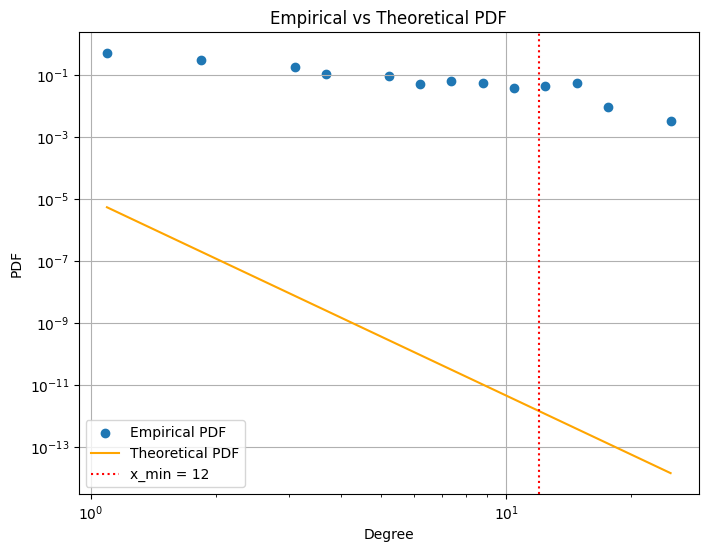

In [123]:
bins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=20)
hist, bin_edges = np.histogram(degrees, bins=bins, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

def power_law_pdf(x, alpha, x_min):
    C = (alpha - 1) / x_min ** (alpha - 1)
    return C * x ** -alpha

pdf_theoretical = power_law_pdf(bin_centers, hat_alpha, hat_x_min)

plt.figure(figsize=(8, 6))
plt.scatter(bin_centers, hist, label="Empirical PDF")
plt.plot(bin_centers, pdf_theoretical, label="Theoretical PDF", color='orange')
plt.axvline(hat_x_min, color="red", linestyle=":", label=f"x_min = {hat_x_min}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("PDF")
plt.title("Empirical vs Theoretical PDF")
plt.legend()
plt.grid()
plt.show()

In [127]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    return x_min * (1 - r)**(1 / (1 - alpha))

In [128]:
def qqplot_data(degrees, alpha, x_min):
    probas = np.arange(0, 1, 0.01)
    empirical = np.quantile(degrees, probas)
    teoretical = power_law_ppf(probas, alpha, x_min)
    return teoretical, empirical

In [129]:
theor, empir = qqplot_data(degrees, hat_alpha, hat_x_min)

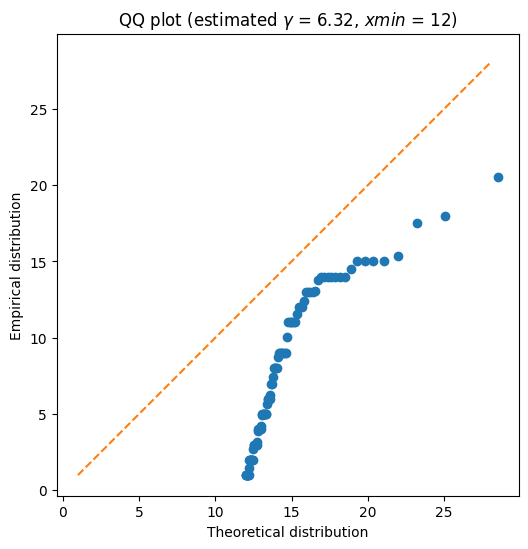

In [156]:
plt.figure(figsize=(6,6))
plt.scatter(theor, empir)
plt.plot([1, max(degrees)+1], [1, max(degrees)+1], '--', c='tab:orange')
plt.title(f'QQ plot (estimated $\gamma$ = {hat_alpha:.2f}, $xmin$ = {hat_x_min})')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square')
plt.show()

# Stuctrure analysis

## Random graph

In [16]:
n = len(G)
en = len(G.edges())
p = 2 * en / (n * (n - 1))
ER = nx.erdos_renyi_graph(n, p)

m = en // n 
BA = nx.barabasi_albert_graph(n, m)

k = 2 * en // n 
p_rewire = 0.1
WS = nx.watts_strogatz_graph(n, k, p_rewire)

In [172]:
print(
    f"Radius:\nReal = {nx.radius(G)}\n"
    f"ER = {nx.radius(ER)}\nBA = {nx.radius(BA)}\nWS = {nx.radius(WS)}"
)

Radius:
Real = 5
ER = 3
BA = 3
WS = 5


In [173]:
print(
    f"Diameter:\nReal = {nx.diameter(G)}\n"
    f"ER = {nx.diameter(ER)}\nBA = {nx.diameter(BA)}\nWS = {nx.diameter(WS)}"
)

Diameter:
Real = 10
ER = 4
BA = 4
WS = 8


In [169]:
print(
    f"Clustering (global):\nReal = {nx.transitivity(G):.4f}\n"
    f"ER = {nx.transitivity(ER):.4f}\nBA = {nx.transitivity(BA):.4f}\nWS = {nx.transitivity(WS):.4f}"
)

Clustering (global):
Real = 0.6292
ER = 0.1113
BA = 0.1263
WS = 0.4887


In [174]:
print(
    f"Clustering (average local):\nReal = {nx.average_clustering(G):.4f}\n"
    f"ER = {nx.average_clustering(ER):.4f}\nBA = {nx.average_clustering(BA):.4f}\nWS = {nx.average_clustering(WS):.4f}"
)

Clustering (average local):
Real = 0.5369
ER = 0.1011
BA = 0.1666
WS = 0.5331


In [175]:
print(
    f"Avg. shortest path:\nReal = {nx.average_shortest_path_length(G):.4f}\n"
    f"ER = {nx.average_shortest_path_length(ER):.4f}\nBA = {nx.average_shortest_path_length(BA):.4f}\nWS = {nx.average_shortest_path_length(WS):.4f}"
)

Avg. shortest path:
Real = 4.0563
ER = 2.3002
BA = 2.4863
WS = 3.8623


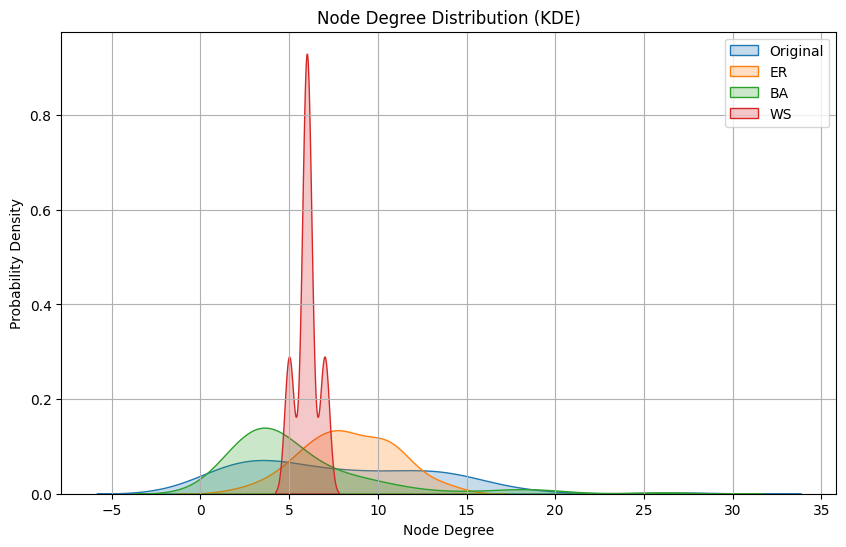

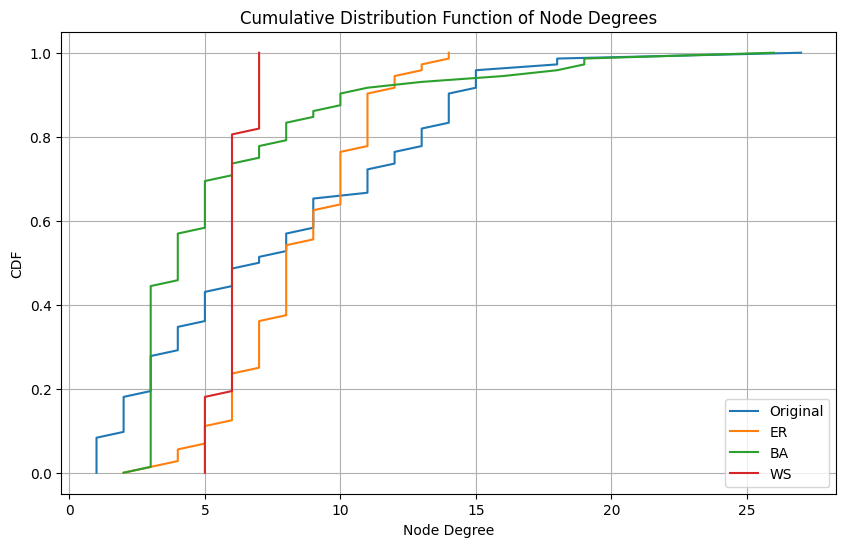

In [18]:
import seaborn as sns

degrees_G = [degree for node, degree in G.degree()]
degrees_ER = [degree for node, degree in ER.degree()]
degrees_BA = [degree for node, degree in BA.degree()]
degrees_WS = [degree for node, degree in WS.degree()]

plt.figure(figsize=(10, 6))

sns.kdeplot(degrees_G, label='Original', fill=True)
sns.kdeplot(degrees_ER, label='ER', fill=True)
sns.kdeplot(degrees_BA, label='BA', fill=True)
sns.kdeplot(degrees_WS, label='WS', fill=True)

plt.xlabel('Node Degree')
plt.ylabel('Probability Density')
plt.title('Node Degree Distribution (KDE)')
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))

def cdf(data):
    n = len(data)
    p = 1. * np.arange(n) / (n - 1)
    return np.sort(data), p

x_G, y_G = cdf(degrees_G)
x_ER, y_ER = cdf(degrees_ER)
x_BA, y_BA = cdf(degrees_BA)
x_WS, y_WS = cdf(degrees_WS)

plt.plot(x_G, y_G, label='Original')
plt.plot(x_ER, y_ER, label='ER')
plt.plot(x_BA, y_BA, label='BA')
plt.plot(x_WS, y_WS, label='WS')

plt.xlabel('Node Degree')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Node Degrees')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Centralities

In [92]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

In [93]:
def get_top_central_nodes(d, top_n=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:top_n]

top_degree = get_top_central_nodes(degree_centrality)
top_closeness = get_top_central_nodes(closeness_centrality)
top_betweenness = get_top_central_nodes(betweenness_centrality)

In [96]:
for idx, centr in top_degree:
    print(f"{nodes_df[nodes_df.id == idx]['name'].iloc[0]}: {centr:.3f}")

Василий Каратетян: 0.375
Илья Сиротин: 0.250
Аня Мгебришвили: 0.250
Дарья Иутина: 0.208
Артем Якуба: 0.208
Мери Казарян: 0.208
Сергей Валиев: 0.208
Максим Сухомлин: 0.194
Денис Сироткин: 0.194
Антон Голышев: 0.194


In [95]:
for idx, centr in top_closeness:
    print(f"{nodes_df[nodes_df.id == idx]['name'].iloc[0]}: {centr:.3f}")

Семён Антонов: 0.353
Iner Hs: 0.338
Эльвин Гасанов: 0.327
Горислав Егоров: 0.323
Denis Antonov: 0.320
Василий Каратетян: 0.320
Аня Мгебришвили: 0.308
Матвей Елисеев: 0.301
Илья Сиротин: 0.300
Дарья Иутина: 0.299


In [97]:
for idx, centr in top_betweenness:
    print(f"{nodes_df[nodes_df.id == idx]['name'].iloc[0]}: {centr:.3f}")

Василий Каратетян: 0.566
Семён Антонов: 0.504
Iner Hs: 0.497
Эльвин Гасанов: 0.221
Горислав Егоров: 0.162
Дарина Егорова: 0.099
Denis Antonov: 0.088
Катя Кусь: 0.082
Аня Мгебришвили: 0.072
Сергей Валиев: 0.072


In [94]:
top_closeness

[(135706227, 0.35294117647058826),
 (360605157, 0.3380281690140845),
 (187783283, 0.32727272727272727),
 (367377220, 0.32286995515695066),
 (210225818, 0.32),
 (233958378, 0.32),
 (135027781, 0.3076923076923077),
 (451426181, 0.301255230125523),
 (130865054, 0.3),
 (172826326, 0.2987551867219917)]

In [195]:
top_betweenness

[(233958378, 0.5662662389775067),
 (135706227, 0.5041930878198483),
 (360605157, 0.49726134585289516),
 (187783283, 0.2211838218293618),
 (367377220, 0.1619166175504204),
 (236801531, 0.09883755394318777),
 (210225818, 0.08837401364890868),
 (347888627, 0.082179186228482),
 (135027781, 0.07194020893674956),
 (466114898, 0.07171813540265479)]

In [199]:
nodes_df = nodes_df.merge(pd.DataFrame(top_degree, columns=['id', 'degree_centrality']), on='id', how='left')
nodes_df = nodes_df.merge(pd.DataFrame(top_closeness, columns=['id', 'closeness_centrality']), on='id', how='left')
nodes_df = nodes_df.merge(pd.DataFrame(top_betweenness, columns=['id', 'betweenness_centrality']), on='id', how='left')

In [200]:
nodes_df.to_csv('nodes2.csv', index=False)

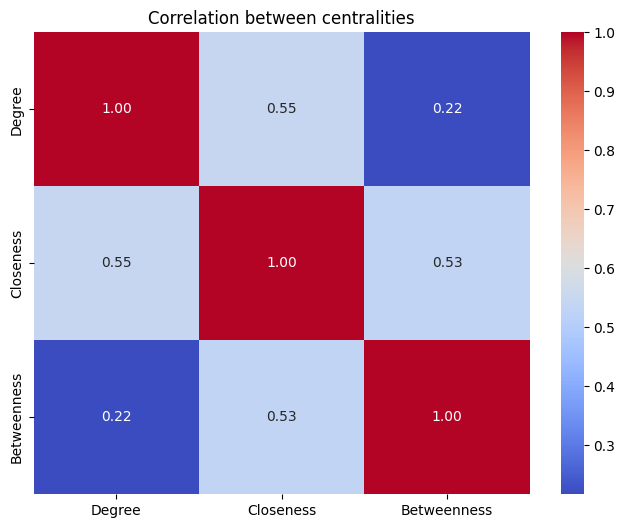

In [203]:
centralities = {
    "Degree": list(degree_centrality.values()),
    "Closeness": list(closeness_centrality.values()),
    "Betweenness": list(betweenness_centrality.values())
}

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(centralities).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between centralities")
plt.show()

In [196]:
top_degree

[(233958378, 0.375),
 (130865054, 0.25),
 (135027781, 0.25),
 (172826326, 0.20833333333333331),
 (230687579, 0.20833333333333331),
 (231446735, 0.20833333333333331),
 (466114898, 0.20833333333333331),
 (166700184, 0.19444444444444442),
 (168449968, 0.19444444444444442),
 (211630257, 0.19444444444444442)]

In [232]:
print("Gender Assortativity:", nx.attribute_assortativity_coefficient(G, 'sex'))
print("City Assortativity:", nx.attribute_assortativity_coefficient(G, 'city'))
print("Education Assortativity:", nx.attribute_assortativity_coefficient(G, 'education_status'))
print("Smoking Assortativity:", nx.attribute_assortativity_coefficient(G, 'smoking'))

Gender Assortativity: 0.010433703682815364
City Assortativity: 0.12303649235141541
Education Assortativity: -0.037780458383594846
Smoking Assortativity: -0.02250205892510866


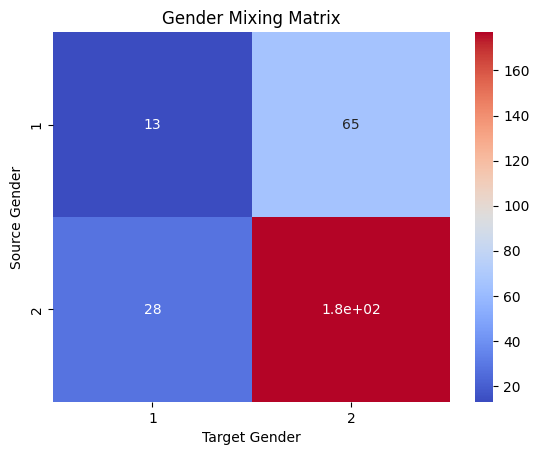

In [233]:
data = pd.DataFrame([(G.nodes[u]['sex'], G.nodes[v]['sex']) for u, v in G.edges], columns=['Source Gender', 'Target Gender'])
cross_tab = pd.crosstab(data['Source Gender'], data['Target Gender'])
sns.heatmap(cross_tab, annot=True, cmap='coolwarm')
plt.title("Gender Mixing Matrix")
plt.show()

## Structural equivalence

In [252]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_neighbors(G_orig):
    G = G_orig.copy()
    G.remove_nodes_from([node for node, degree in G.degree() if degree <= 10])
    nodes = list(G.nodes)
    adj_matrix = nx.to_numpy_array(G, nodelist=nodes)
    similarities = cosine_similarity(adj_matrix)
    return similarities, nodes

cosine_similarities, node_list = cosine_similarity_neighbors(G)

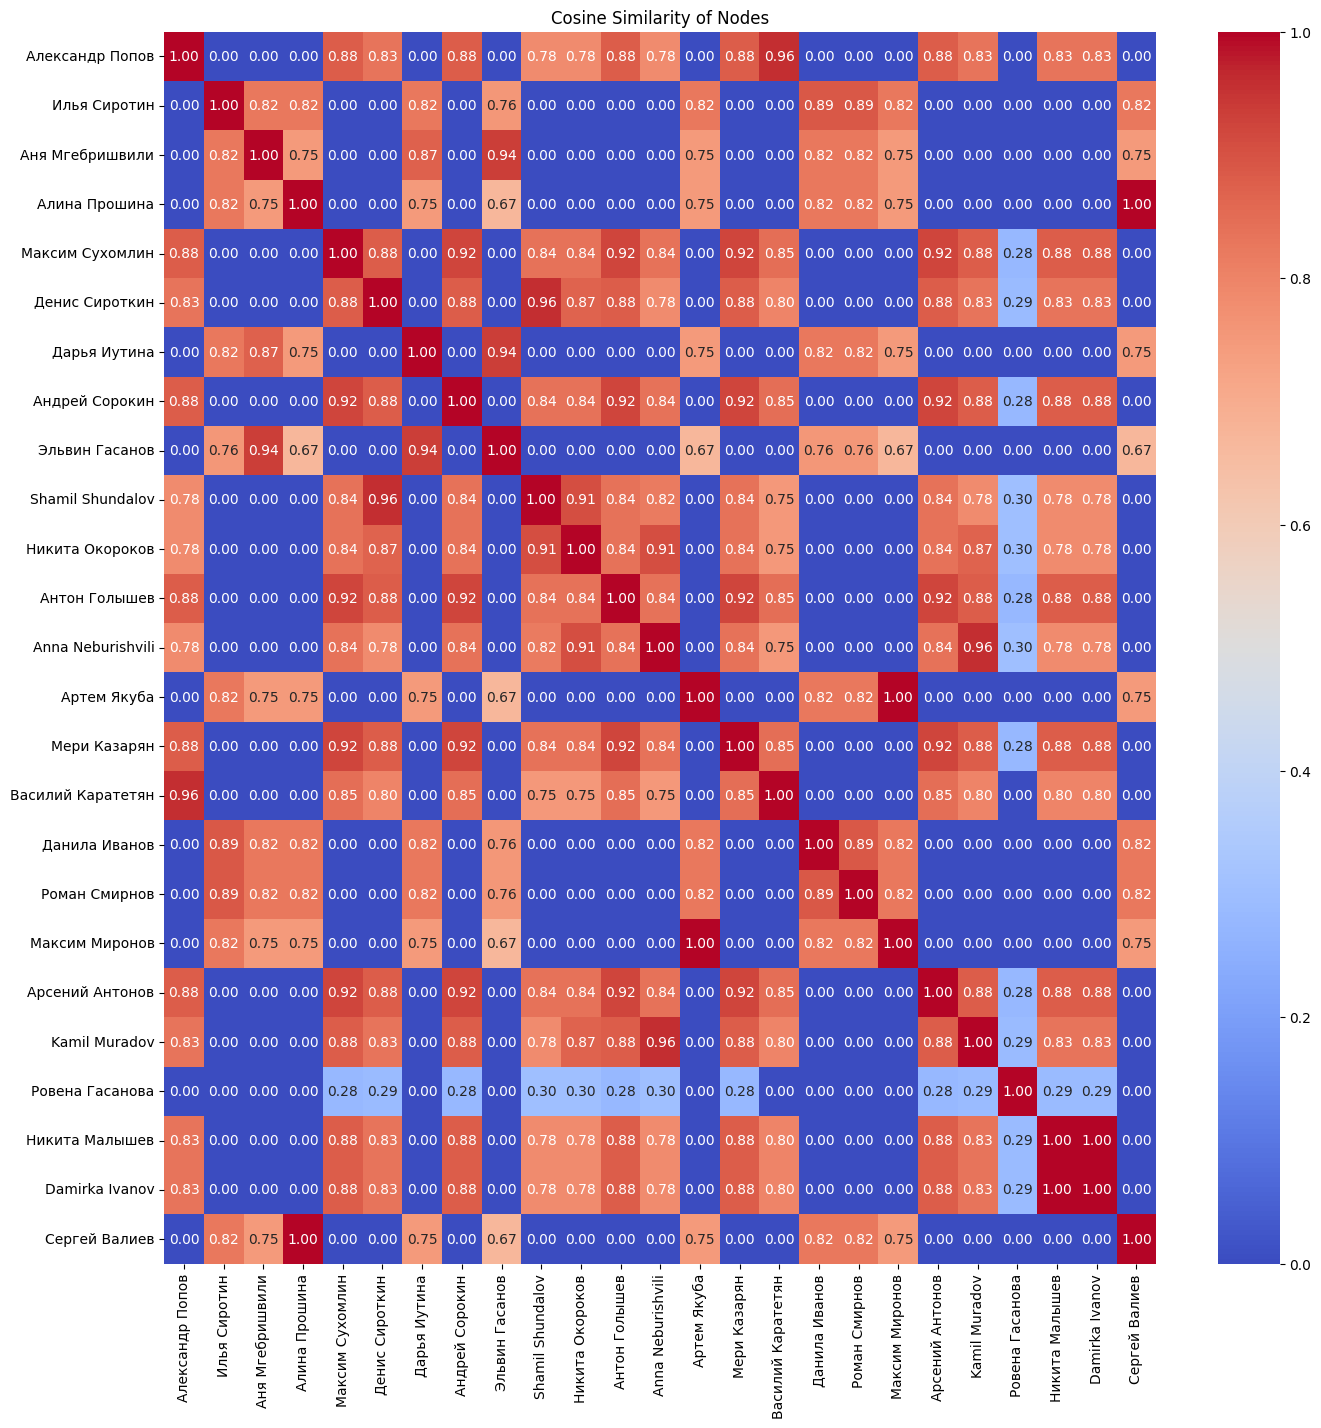

In [254]:
plt.figure(figsize=(16,16))

cos_sim_df = pd.DataFrame(
    cosine_similarities,
    index=[G.nodes(data=True)[node]['name'] for node in node_list],
    columns=[G.nodes(data=True)[node]['name'] for node in node_list]
)
sns.heatmap(
    cos_sim_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Cosine Similarity of Nodes")
plt.show()

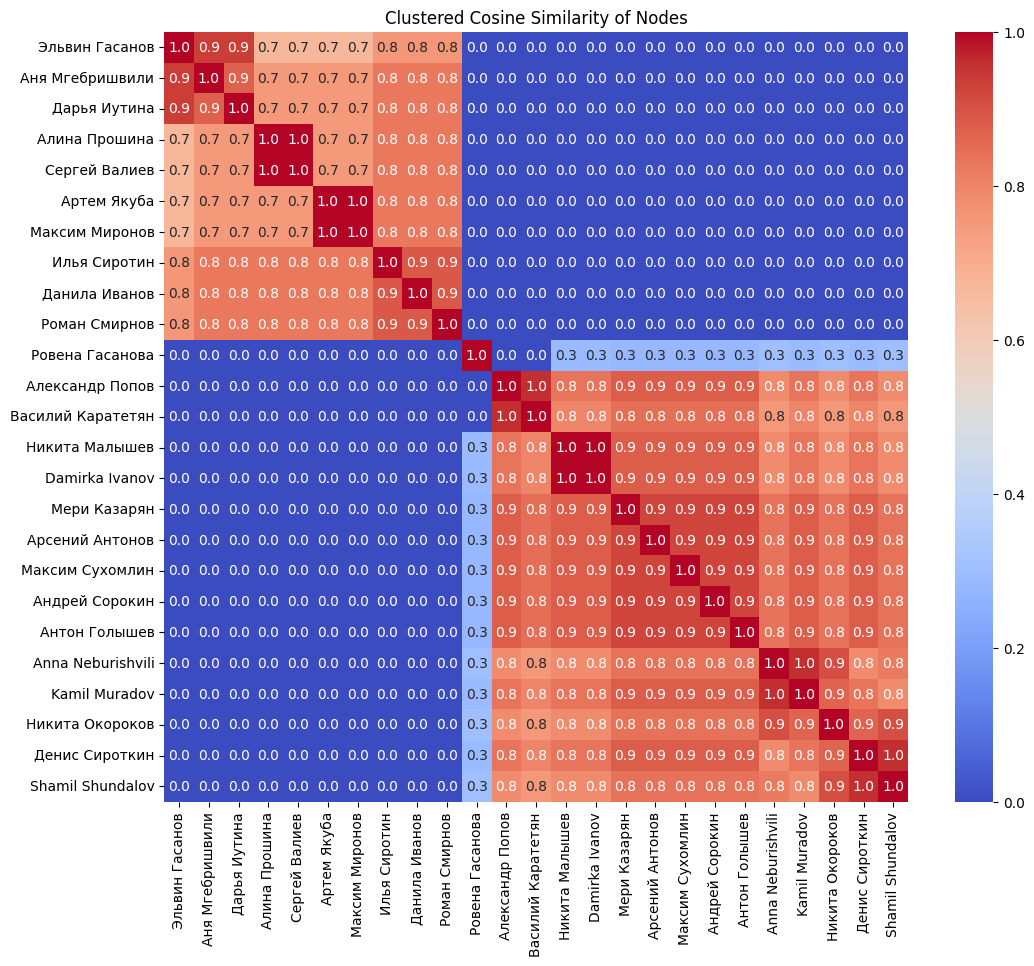

In [265]:
from scipy.cluster.hierarchy import linkage, leaves_list

linkage_matrix = linkage(cosine_similarities, method='ward')
ordered_indices = leaves_list(linkage_matrix)

reordered_cos_sim_df = cos_sim_df.iloc[ordered_indices, ordered_indices]

plt.figure(figsize=(12,10))
sns.heatmap(
    reordered_cos_sim_df,
    annot=True,
    cmap="coolwarm",
    fmt=".1f"
)
plt.title("Clustered Cosine Similarity of Nodes")
plt.show()

# Community detection

## Clique detection

In [27]:
top_cliques = list(nx.find_cliques(G))
max_len = max(len(c) for c in top_cliques)
top_cliques = [c for c in top_cliques if len(c) == max_len]

In [33]:
for i, clique in enumerate(top_cliques):
    nodes_df[f'clique_{i}'] = 0
    nodes_df.loc[nodes_df.id.isin(clique), f'clique_{i}'] = 1

In [35]:
nodes_df.to_csv('nodes_w_cliques.csv', index=False)

In [36]:
nodes_df[[col for col in nodes_df if 'clique' in col]].sum()

clique_0    10
clique_1    10
clique_2    10
clique_3    10
dtype: int64

## Modularity

In [10]:
def modularity(A, communities):
    m = A.sum() / 2
    res = (A - expected_edges(A, m)) * kronecker(A, communities)
    return res.sum() / 2 / m

def expected_edges(A, m):
    A_bool = A != 0
    k_i = A_bool.sum(axis=0)
    k_j = A_bool.sum(axis=1)
    return k_j * k_i.reshape(-1, 1) / (2 * m)

def kronecker(A, communities):
    n = A.shape[0]
    labels = np.zeros(n, dtype=int)
    for idx, community in enumerate(communities):
        for node in community:
            labels[node] = idx
    return (labels[:, None] == labels[None, :]).astype(int)

# def edge_betw_modularity(G, n):
#     modularities = np.zeros(n)
#     _G = G.copy()
#     A = nx.to_numpy_array(G)
#     for i in range(n):
#         remove_bridges(_G)
#         communities = list(nx.connected_components(_G))
#         mod = modularity(A, communities)
#         modularities[i] = mod
#     return modularities

## Laplacian eigenmaps + K-means

In [29]:
from sklearn.cluster import KMeans
from copy import deepcopy
from sklearn.metrics import silhouette_score

In [12]:
def norm_laplacian(A):
    D = np.diag(A.sum(axis=0))
    D_ = np.diag(D.diagonal() ** (-1/2))
    L = D_ @ (D - A) @ D_
    return L

def spectral_embedding(L, n_components):
    vals, vecs = np.linalg.eigh(L)
    return vecs[:, 1:1 + n_components]

def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L = norm_laplacian(A)
    embedding = spectral_embedding(L, n_components)
    kmeans = KMeans(n_clusters=n_clusters, random_state=1)
    kmeans.fit(embedding)
    return kmeans.labels_

In [83]:
silhouettes = []
modularities = []
cluster_range = list(range(2, 12))
n_components = 3

all_labels['laplacian'] = {}

for n_clusters in cluster_range:
    A = nx.to_numpy_array(G)

    labels = spectral_clustering(G, n_clusters, n_components=n_components)
    all_labels['laplacian'][n_clusters] = deepcopy(dict(zip(nx.get_node_attributes(G, 'id'), labels)))
    communities = [np.arange(len(G))[np.array(labels) == label] for label in np.unique(labels)]

    mod = modularity(A, communities)
    modularities.append(mod)

    L = norm_laplacian(A)
    embedding = spectral_embedding(L, n_components=n_components)
    silhouette = silhouette_score(embedding, labels)
    silhouettes.append(silhouette)

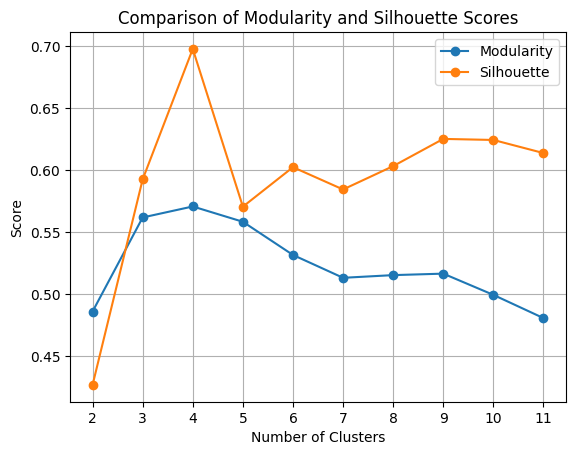

In [84]:
plt.plot(cluster_range, modularities, label="Modularity", marker="o")
plt.plot(cluster_range, silhouettes, label="Silhouette", marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.xticks(cluster_range)
plt.legend()
plt.title("Comparison of Modularity and Silhouette Scores")
plt.grid()
plt.show()

In [85]:
pos = nx.kamada_kawai_layout(G)

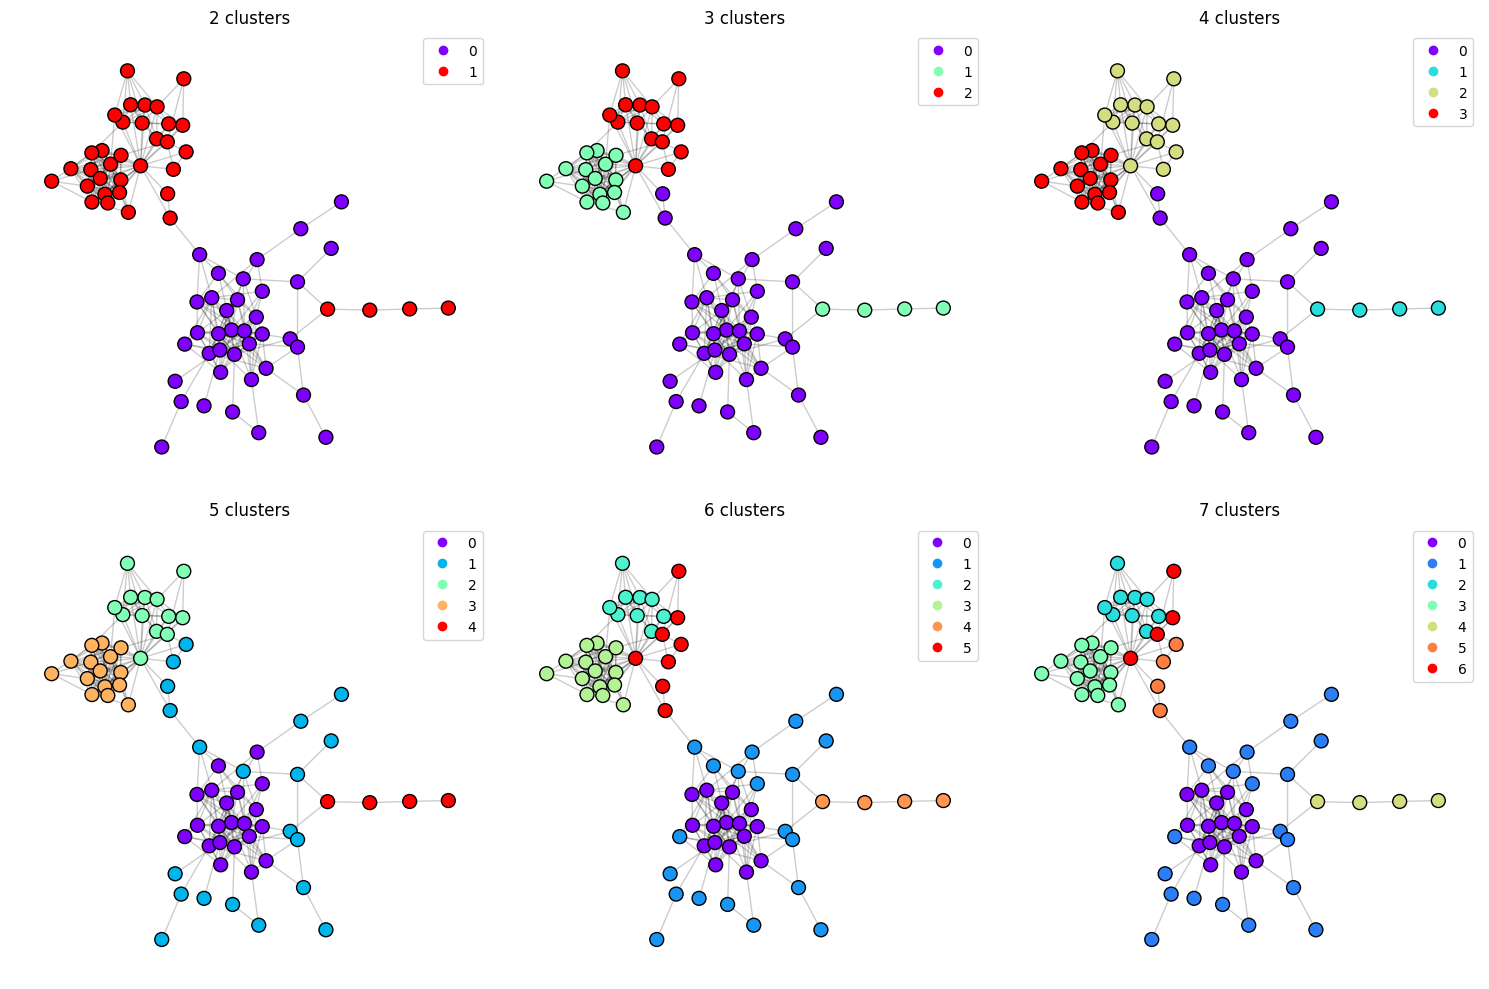

In [86]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes = axes.flatten()

for i, (n_clusters, labels) in enumerate(list(all_labels['laplacian'].items())[:6]):
    ax = axes[i]
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        cmap=plt.cm.rainbow,
        node_color=list(labels.values()),
        node_size=100,
        linewidths=1,
        edgecolors='black',
        ax=ax
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.2,
        edge_color='black',
        ax=ax
    )
    ax.set_title(f"{n_clusters} clusters")
    ax.axis('off')
    legend = ax.legend(*nodes.legend_elements(), loc="upper right")
    legend.set_draggable(True)

plt.tight_layout()
plt.show()

## K-core decomposition

In [111]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

In [112]:
pos = nx.kamada_kawai_layout(G)

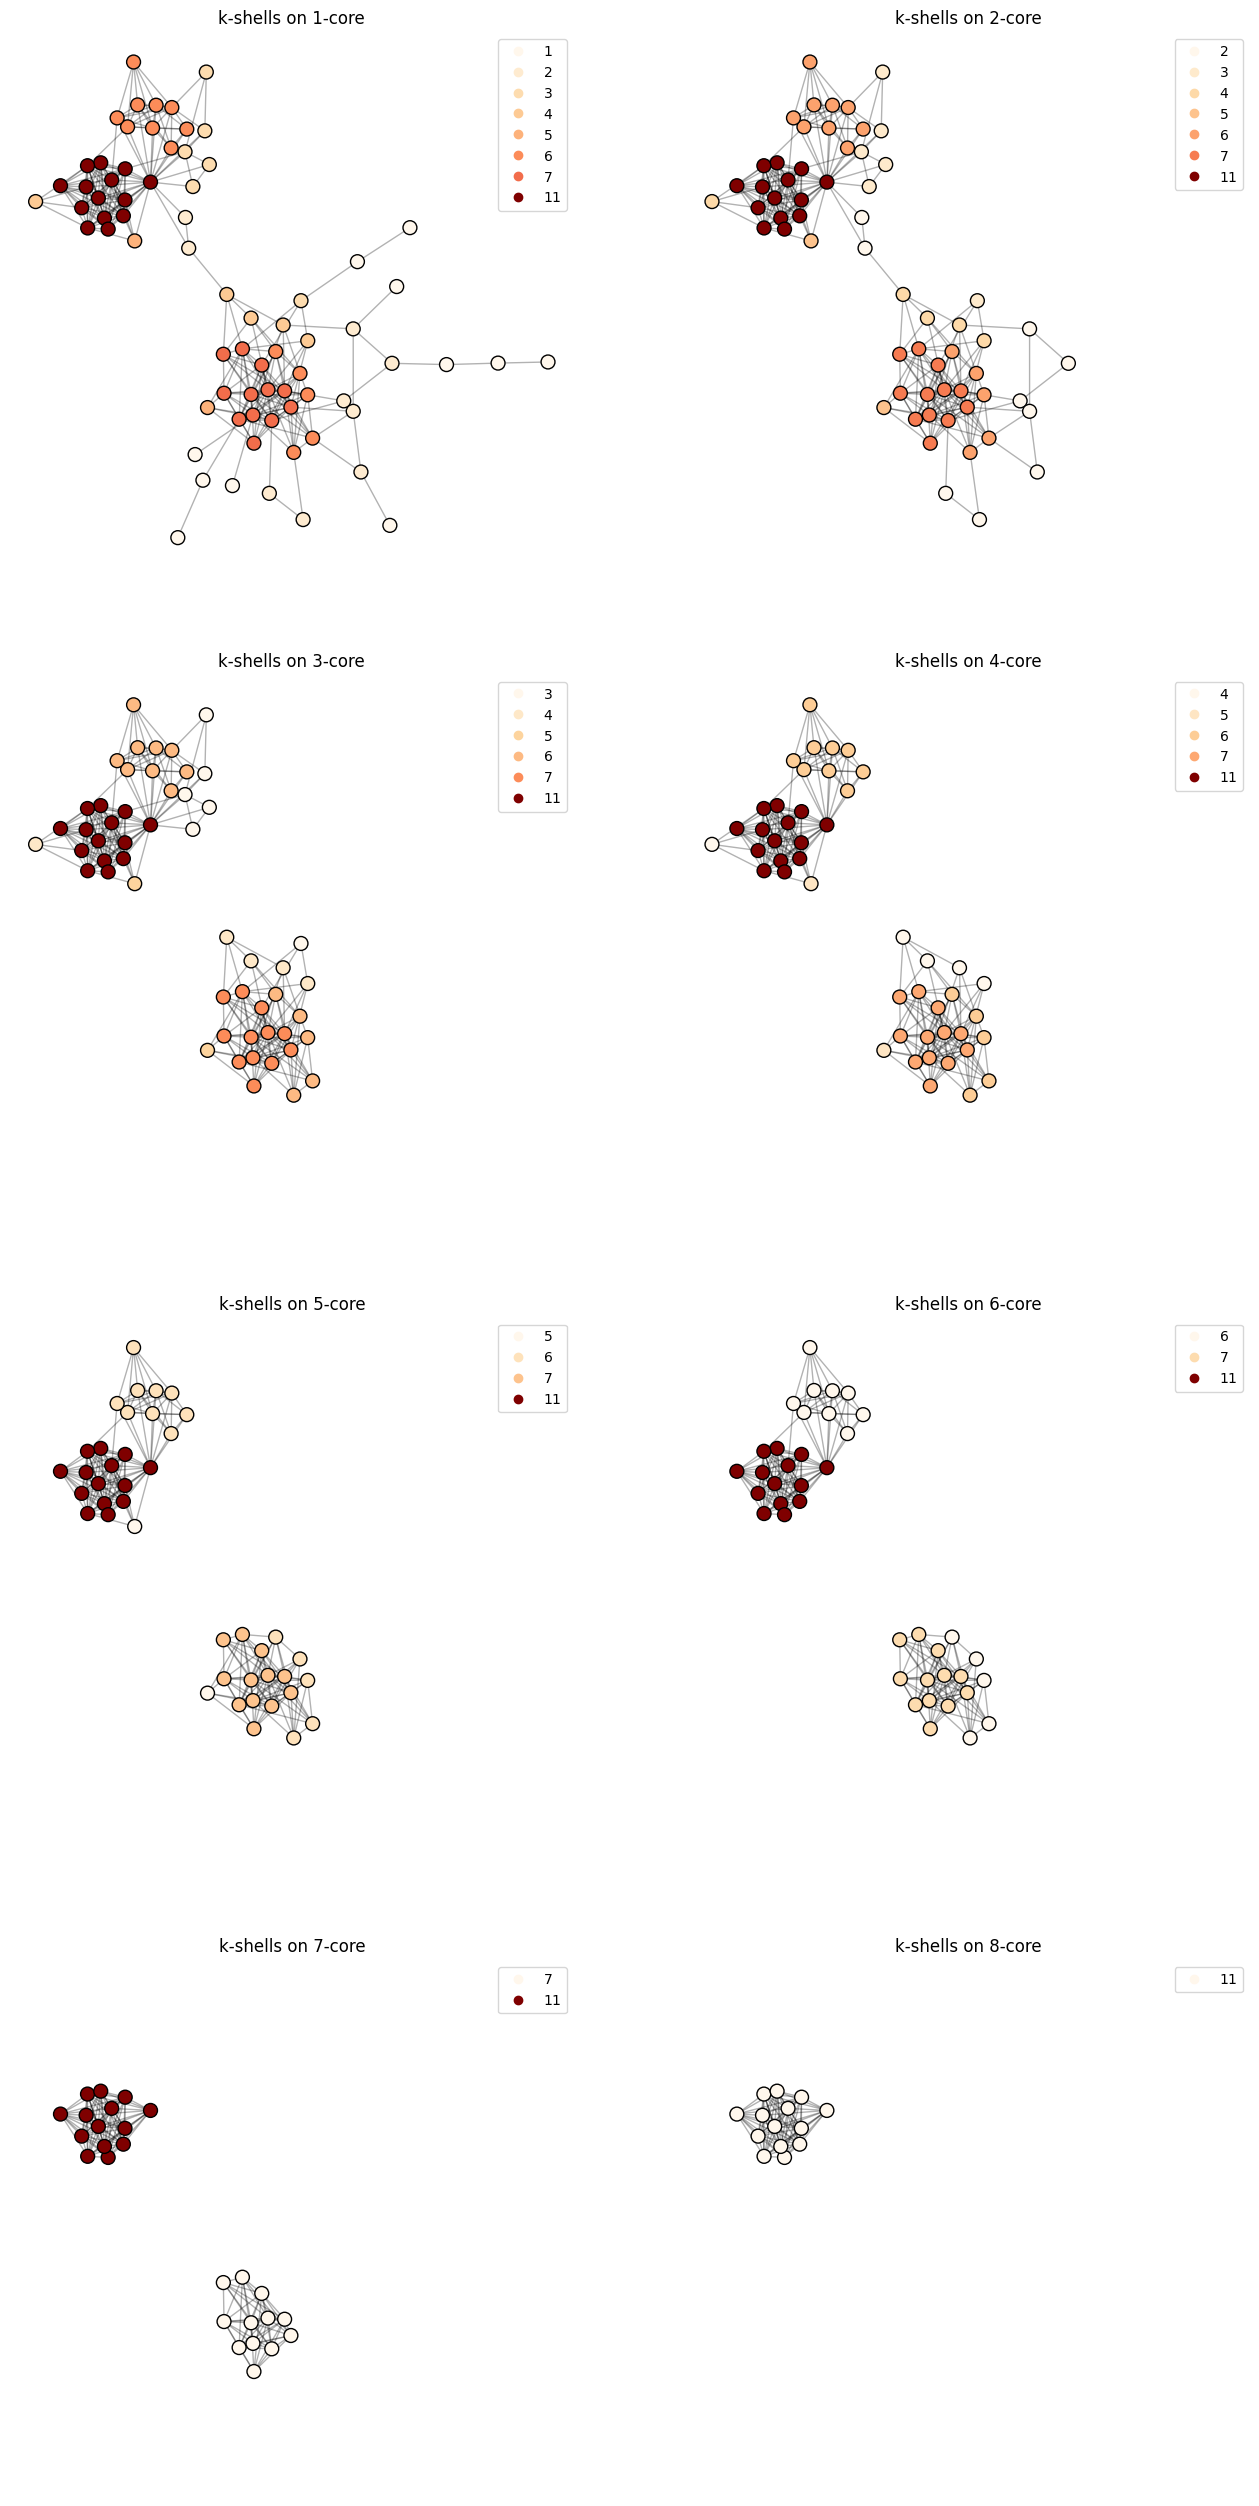

In [116]:
plt.figure(figsize=(8*2, 8*4))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(G, i+1)
    nodes = nx.draw_networkx_nodes(
        subG,
        pos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(subG),
        node_size=100,
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG,
        pos,
        alpha=0.3,
        width=1,
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

## Girvan-Newman algorithm

In [20]:
from tqdm.notebook import trange

In [21]:
def girvan_newman(G, n):
    labels = np.zeros((n, len(G)))
    _G = G.copy()
    for division in range(n):
        remove_bridges(_G)
        for i, cc in enumerate(nx.connected_components(_G)):
            labels[division, list(cc)] = i
    return labels

def remove_bridges(G):
    init_len = len(list(nx.connected_components(G)))
    while len(list(nx.connected_components(G))) == init_len:
        eb = nx.edge_betweenness(G)
        G.remove_edges_from([max(eb, key=eb.get)])

In [37]:
silhouettes = []
modularities = []

all_labels['girvan-newman'] = []

n_iterations = 20

_G = G.copy()
A = nx.to_numpy_array(G)

for i in trange(n_iterations):
    remove_bridges(_G)
    
    communities_idx = list(nx.connected_components(_G))
    communities = []
    for com in communities_idx:
        communities.append([list(G.nodes).index(node) for node in com])
    
    labels = np.array(
        [[i for i, com in enumerate(communities) if node in com][0] for node in range(len(G))]
    )
    all_labels['girvan-newman'].append(
        deepcopy(dict(zip(nx.get_node_attributes(G, 'id'), labels)))
    )
    
    mod = modularity(A, communities)
    modularities.append(mod)
    
    silhouette = silhouette_score(embedding, labels)
    silhouettes.append(silhouette)

  0%|          | 0/20 [00:00<?, ?it/s]

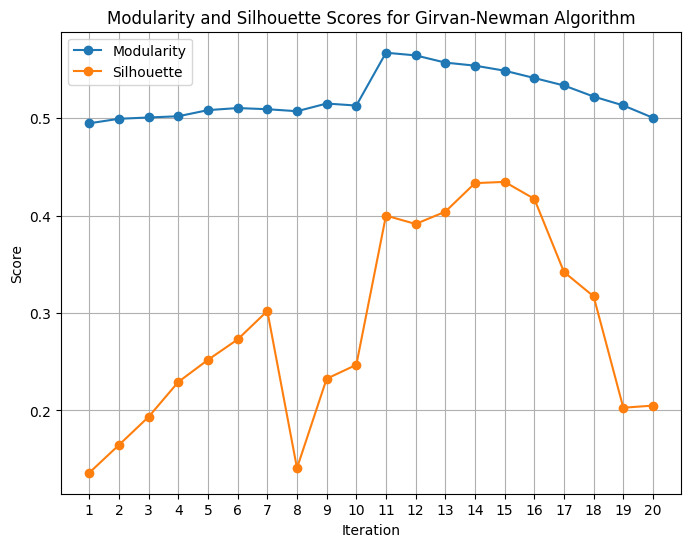

In [38]:
plt.figure(figsize=(8,6))
plt.plot(range(1, n_iterations + 1), modularities, label="Modularity", marker="o")
plt.plot(range(1, n_iterations + 1), silhouettes, label="Silhouette", marker="o")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.legend()
plt.title("Modularity and Silhouette Scores for Girvan-Newman Algorithm")
plt.grid()
plt.xticks(list(range(1, n_iterations+1)))
plt.show()

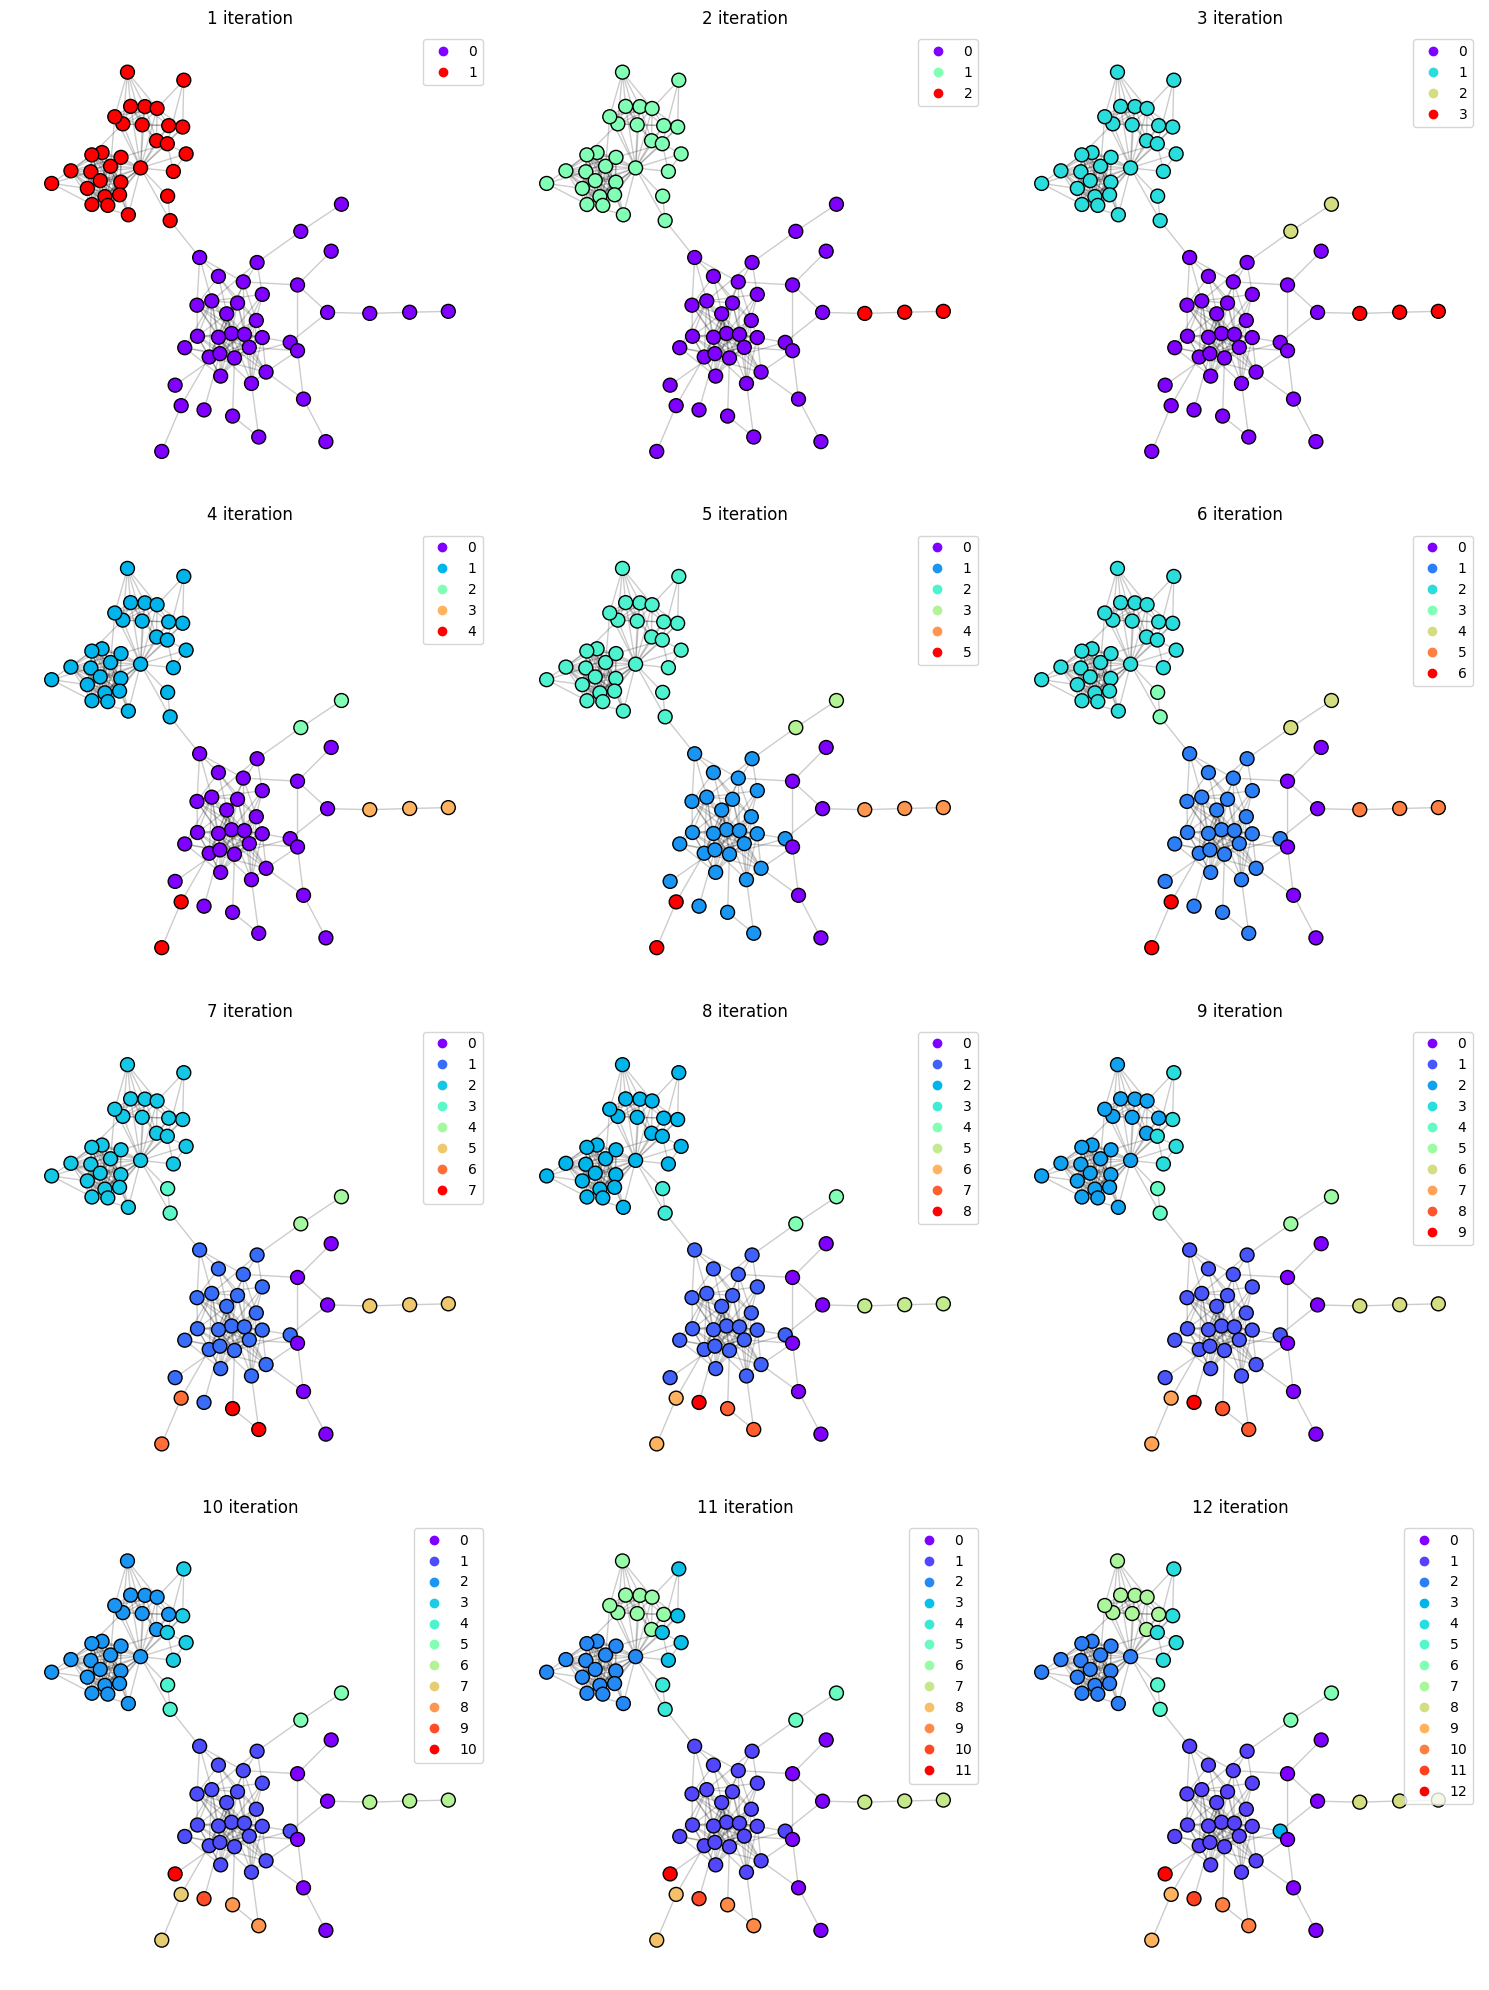

In [90]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, labels in enumerate(all_labels['girvan-newman'][:12]):
    ax = axes[i]
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        cmap=plt.cm.rainbow,
        node_color=list(labels.values()),
        node_size=100,
        linewidths=1,
        edgecolors='black',
        ax=ax
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.2,
        edge_color='black',
        ax=ax
    )
    ax.set_title(f"{i+1} iteration")
    ax.axis('off')
    legend = ax.legend(*nodes.legend_elements(), loc="upper right")
    legend.set_draggable(True)

plt.tight_layout()
plt.show()